In [1]:
import os, sys
script_dir = os.getcwd()
module_path = script_dir
for _ in range(1):
    module_path = os.path.abspath(os.path.join(module_path, '../'))
    if module_path not in sys.path:
        sys.path.insert(0,module_path)


from src.LLM_inference.llm_decode import decode_moddeling
from src.LLM_inference.llm_prefill import prefill_moddeling
from variables import *

/Users/abambhaniya3/.local/lib/python3.12/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
## Library and inputs
import plotly.express as px
import pandas as pd
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import numpy as np

import plotnine as p9
from plotnine import ggplot, aes, geom_point, geom_line, labs, element_text

In [3]:
# This will reload the imported modules (e.g. src.analysis, src.model) every time you execute the jupyter cells, so that you don't need to restart the notebook after updating the source codes.
%load_ext autoreload
%autoreload 2

In [4]:
prefill_moddeling(model = 'LLaMA_70b', batch_size = 2,
                                    input_tokens = 2048, output_tokens = 256, FLAT = True,
                                    system_name = {'Flops': 200, 'Memory_size': 32, 'Memory_BW': 1000, 'ICN': 300 , 'real_values':True},
                                    bits='bf16',
                                    tensor_parallel = 1, pipeline_parallel = 16, debug=False, time_breakdown=True) 


{'Latency': 2916.9238136064,
 'Throughput': 10.969654570401184,
 'Runtime_breakdown': [2803.7546508288, 109.95116277759999, 3.218],
 'is_offload': False}

In [5]:
total_nodes = 8
PP_parallelism = [1,2,4,8]
data = []

for model in ['mixtral_7x8',  'gpt-3']:
    for total_batch_size in [1,2,4,8,16,32,48,64,80,96,112,128,136,144,160, 172, 180, 200, 224, 240, 256]:
        for i in PP_parallelism:
            try:
                if i <= total_batch_size:
                    batch_size = (total_batch_size//i)
                    prefill_outputs = prefill_moddeling(model = model, batch_size = batch_size,
                                            input_tokens = 4000, output_tokens = 256, FLAT = True,
                                            system_name = 'H100',
                                            bits='int8',
                                            tensor_parallel = (total_nodes//i), pipeline_parallel = i, debug=False, time_breakdown=True) 
                    data.append([model,'Prefill',total_batch_size, total_nodes//i, i , prefill_outputs['Latency'], prefill_outputs['Throughput']] + prefill_outputs['Runtime_breakdown'])
                    batch_size = (total_batch_size//i)
                    decode_outputs = decode_moddeling(model = model, batch_size = batch_size, Bb = 4 ,
                                            input_tokens = 4000, output_tokens = 256, FLAT = True,
                                            system_name = 'H100',
                                            bits='int8',
                                            tensor_parallel = (total_nodes//i), pipeline_parallel = i, debug=False, time_breakdown=True) 
                    data.append([model,'Decode',total_batch_size, total_nodes//i, i ,  decode_outputs['Latency'], decode_outputs['Throughput']] + decode_outputs['Runtime_breakdown'])
            except ValueError:
                pass
data_df = pd.DataFrame(data, columns = ['Model', 'Stage','# Batch','TP', 'PP', 'Latency(ms)', 'Tokens/s', 'GEMM Time', 'Attn Time', 'Communication Time'])
data_df['uB'] = data_df['# Batch'] / data_df['PP']
data_df = data_df.replace(Model_list, Model_names_in_plot)

In [6]:
data_df['Model'] = pd.Categorical(data_df['Model'], categories=Model_names_in_plot)
data_df['PP'] = pd.Categorical(data_df['PP'], categories=PP_parallelism)
data_df['Parallelism'] = data_df['PP'].astype(str)
data_df.replace(to_replace={"1": "TP:8+PP:1", "2": "TP:4+PP:2", "4": "TP:2+PP:4", "8": "TP:1+PP:8"}, inplace=True)
data_df['Parallelism'] = pd.Categorical(data_df['Parallelism'], categories=["TP:8+PP:1", "TP:4+PP:2", "TP:2+PP:4", "TP:1+PP:8"])
data_df['Stage'] = pd.Categorical(data_df['Stage'], categories=['Prefill','Decode'])
data_df['Label'] = ""
data_df['Label'] = data_df.apply(lambda row: row['Parallelism'].replace("+","\n") if row['# Batch'] == 80 and row['Stage'] == 'Decode' else row['Label'] , axis=1)
data_df['Label'] = data_df.apply(lambda row: row['Parallelism'] if row['# Batch'] == 32 and row['Stage'] == 'Prefill' else row['Label'] , axis=1)


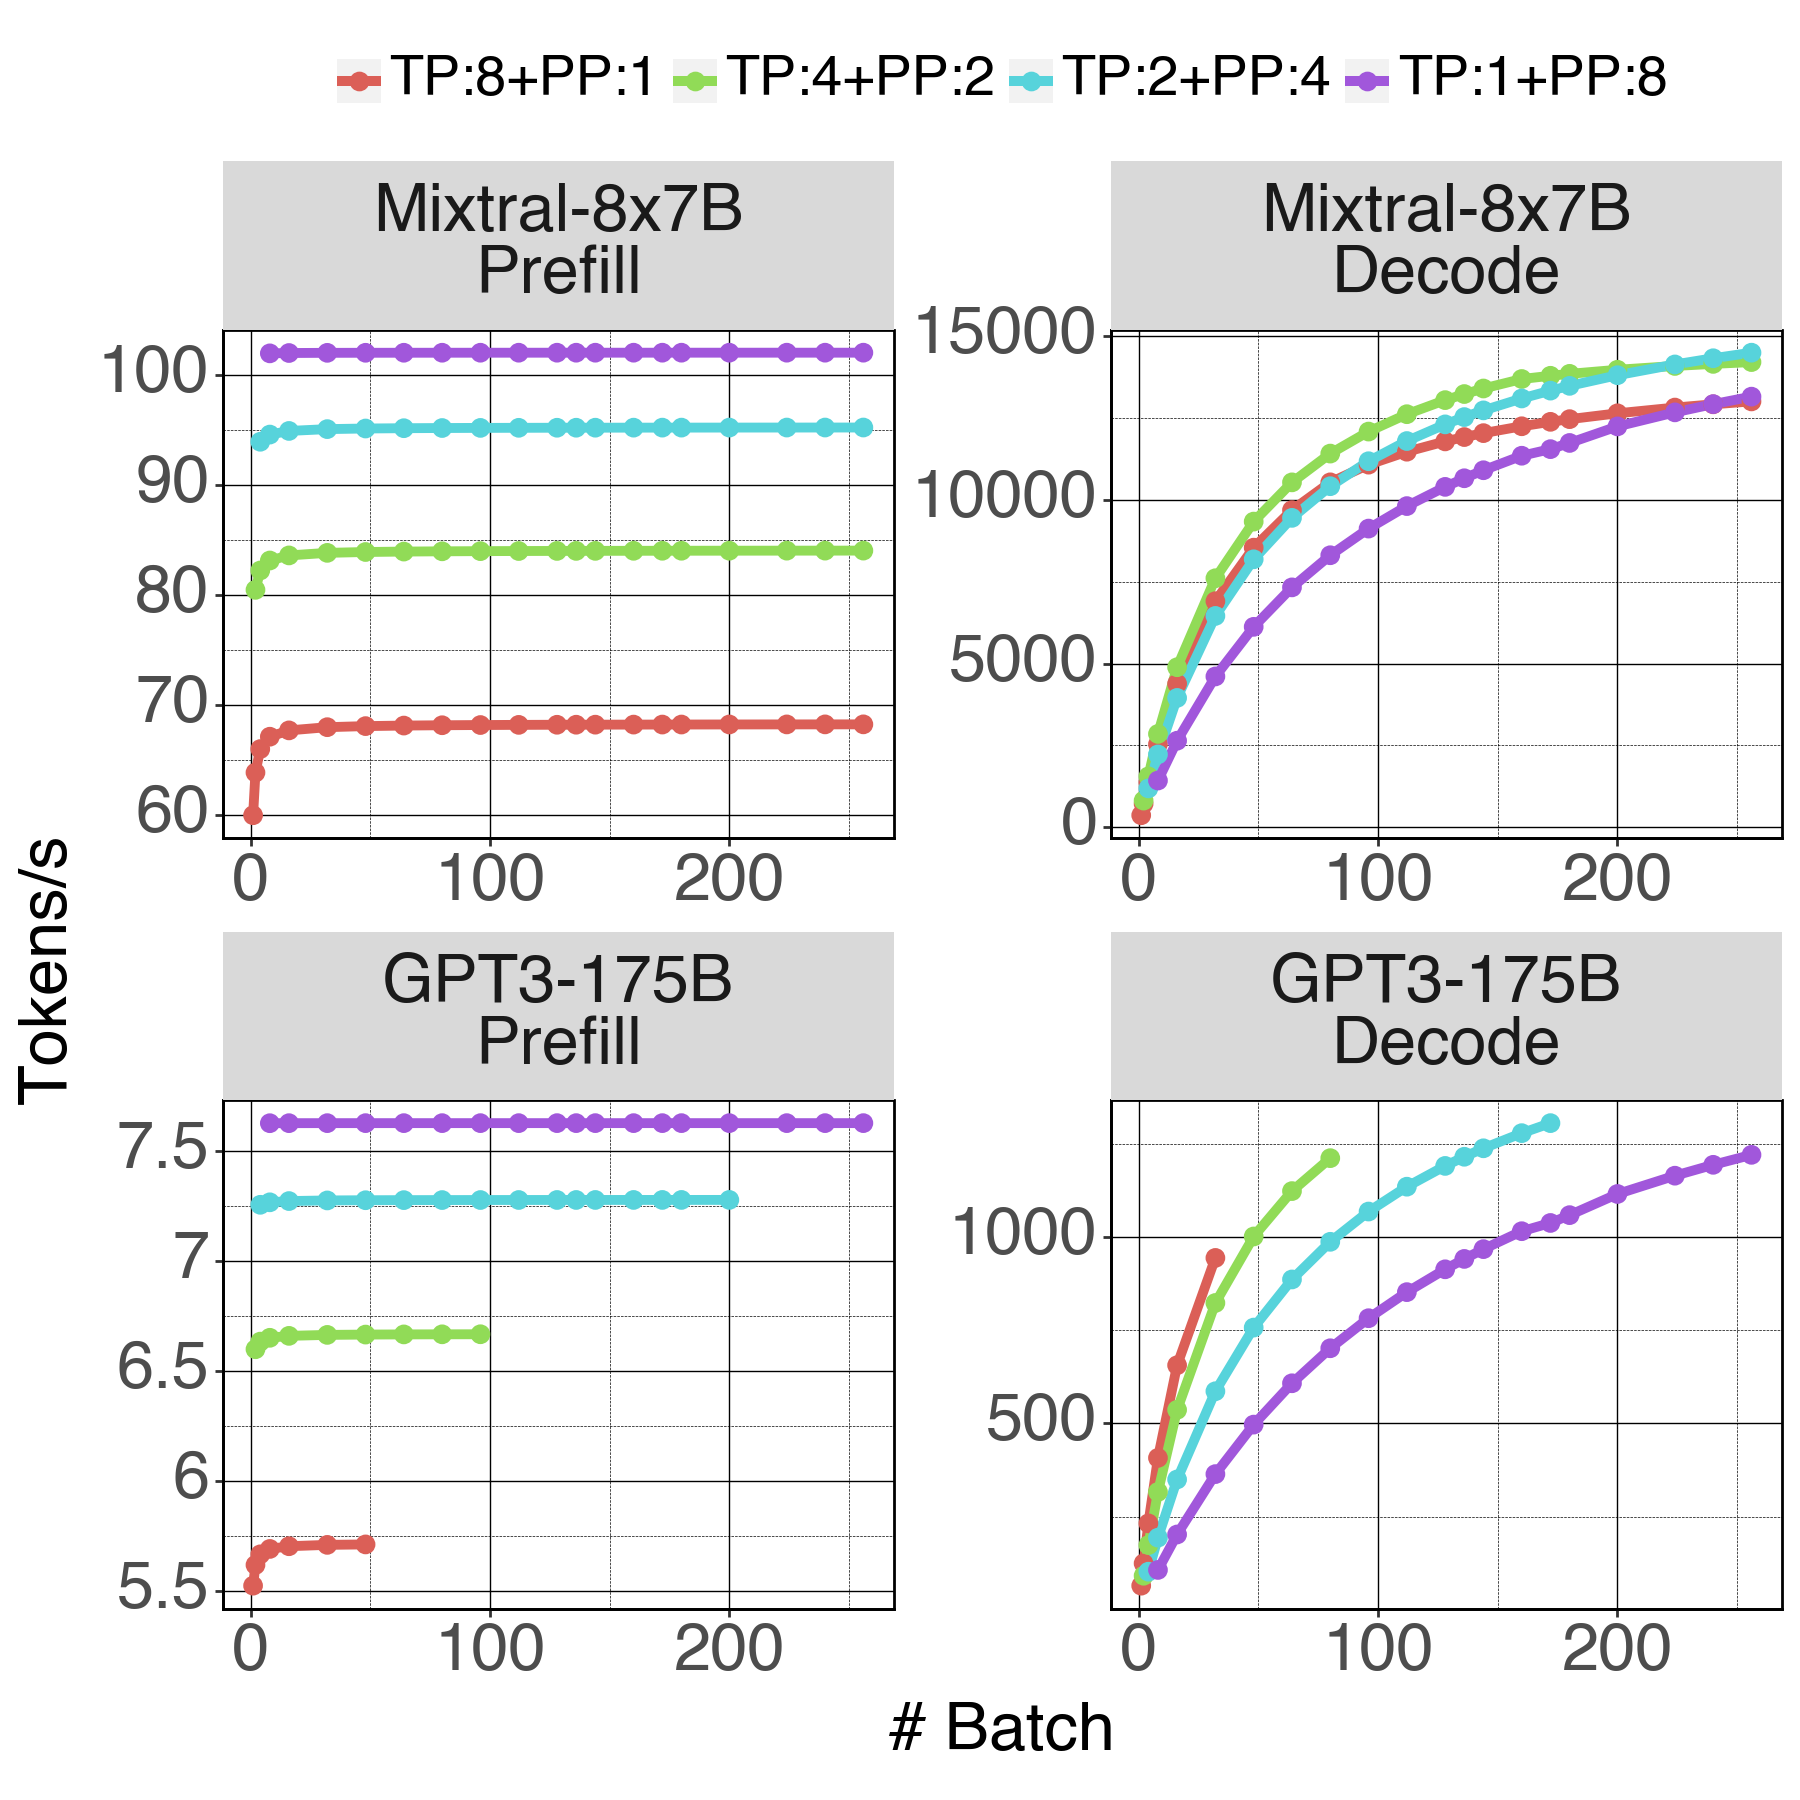

In [7]:

# data_df.replace(to_replace={"1.0": "TP:32+PP:1", "2.0": "TP:16+PP:2", "4.0": "TP:8+ PP:4", "8.0": "TP:4+ PP:8", "16.0": "TP:2+ PP:16",  "32.0": "TP:1+ PP:32", }, inplace=True)
# data_df['# Batch'] = data_df['# Batch'].astype(str)

p1 = (
    p9.ggplot(data_df, p9.aes(x='# Batch', y='Tokens/s'))
    + p9.geom_line(p9.aes( color = 'Parallelism'),size=2) # line plot
    + p9.geom_point(p9.aes( color = 'Parallelism' ),size=3) # line plot
    + plot_theme
    + p9.theme(  
        figure_size=(9,9),
        legend_position='top'
        ,legend_title=p9.element_blank()
        ,legend_text=p9.element_text(size=20)
        ) # Ast title size
    + p9.facet_wrap("~ Model + Stage ", scales = 'free' , ncol= 2)
)

print(p1)


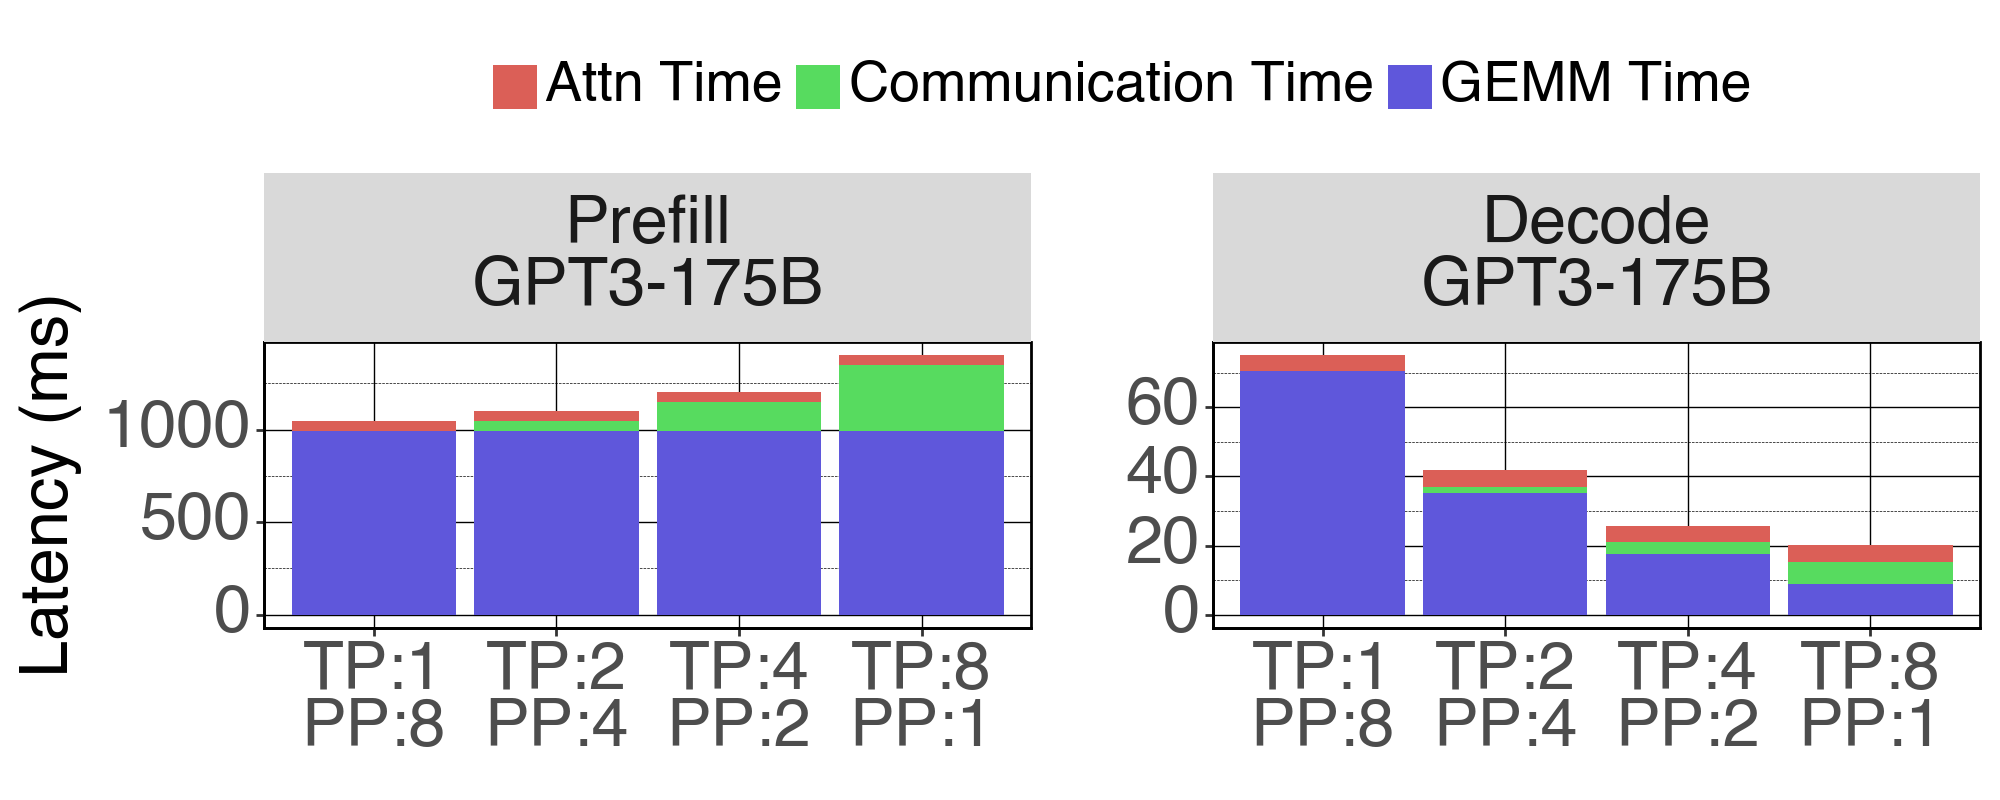

/opt/homebrew/Caskroom/miniconda/base/envs/modesa_dev/lib/python3.12/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 10 x 4 in image.
/opt/homebrew/Caskroom/miniconda/base/envs/modesa_dev/lib/python3.12/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: /Users/abambhaniya3/Dropbox (GaTech)/Projects/GPT inference/Micro/parallelism_time_breakdown.pdf


In [8]:
df_long = pd.melt(data_df[(data_df['# Batch'] == 8) & (data_df['Model'] == 'GPT3-175B')], id_vars=['Stage', 'Model', '# Batch', 'TP',
       'PP',  'Latency(ms)', 'Tokens/s', 'uB',
       'Label', 'Parallelism'], var_name="Time")
df_long['value'] = df_long['value'].astype(float)
df_long = df_long.replace(Model_list, Model_names_in_plot)
df_long['Label'] = df_long.apply(lambda x: x['Parallelism'].replace("+","\n"), axis=1)
# for _usecase_ in df_long['Usecase'].unique():
plot = (
    ggplot(df_long, aes(x='Label',y='value',fill ='Time'))
    + p9.geom_bar(stat='identity',position='stack') 
    + p9.labs(y='Latency (ms)', x='')
    + plot_theme
    + p9.theme(axis_text_x=p9.element_text(), axis_title_x=p9.element_blank())
    + p9.theme(figure_size=(10, 4),legend_text=p9.element_text(size=20),legend_title=p9.element_blank(),axis_title_x=p9.element_text(size=16),)
    + p9.theme( legend_position='top')
    # + p9.geom_segment(pd.DataFrame({'x': [0.15], 'y': [260], 'xend': [0.4], 'yend': [470]}), aes(x='x', y='y', xend='xend', yend='yend'), arrow=p9.arrow(), size = 2, color='red')
    # + p9.geom_text(p9.aes(x = 0.35, y = 325),label = f"As # Batch inc.: \n PP gives higher \n thrpt than TP  ", size=25)
    + p9.facet_wrap("~ Stage + Model", scales = 'free' , ncol=2)
    # + p9.faceh_wrap("Usecase", scales = 'free' , )
)
print(plot)